In [16]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import SystemMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.prompts import ChatPromptTemplate

# Corrected planner_prompt
planner_prompt = ChatPromptTemplate.from_template(
    """
    Here is a list of ingredients: 
    {messages}

    Based on this list, create only one recipe and make sure to clearly label: 
    - Recipe Name
    - Ingredients with specific quantities or weights
    - Cooking Instructions with step-by-step guide
    The recipe should be creative, easy to follow, and suitable for a home-cooked meal.
    """
)



tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

planner = planner_prompt | llm_with_tools

# Corrected structure_prompt
structure_prompt = ChatPromptTemplate.from_template(
    """
    The only job is structure the recipe into JSON format, containing:
    - recipe_name
    - instructions
    - ingredients.

    Each of json value should be markdown formatted.

    {messages}
    """
)

structure = structure_prompt | ChatOpenAI(
    model="gpt-3.5-turbo-0125", temperature=0
)


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def generate_recipe(state: State):
    return {"messages": [planner.invoke(state["messages"])]}

def structured_output(state: State):
    return {"messages": [structure.invoke(state["messages"])]}


graph_builder.add_node("recipe", generate_recipe)
graph_builder.add_node("structured", structured_output)

graph_builder.add_edge(START, "recipe")
graph_builder.add_edge("recipe", "structured")
graph_builder.add_edge("structured", END)

In [18]:
graph = graph_builder.compile(checkpointer=memory)

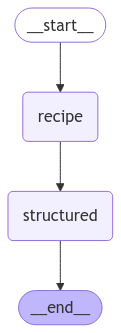

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
# user_input = "Tomato, Mushroom, Green Bell Pepper, Onion, Garlic, Egg, Chicken Breast, Tofu, Milk, Cheese, Yogurt, Lettuce, Cooked Rice, Bacon, Lemon"

user_input = "Tomato, Mushroom, Green Bell Pepper, Onion, Garlic, Egg, Chicken, Cheese, Yogurt"

# "Tomato, Mushroom, Green Bell Pepper, Onion, Garlic, Egg, Chicken Breast, Tofu, Milk, Cheese, Yogurt, Lettuce, Cooked Rice, Bacon, Lemon"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.invoke(
    {"messages": user_input}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Tomato, Mushroom, Green Bell Pepper, Onion, Garlic, Egg, Chicken, Cheese, Yogurt
================================== Ai Message ==================================

**Recipe Name: Mediterranean Chicken and Vegetable Skillet**

**Ingredients:**
- 2 medium Tomatoes, diced
- 1 cup Mushrooms, sliced
- 1 Green Bell Pepper, chopped
- 1 Onion, sliced
- 3 cloves Garlic, minced
- 2 Eggs
- 2 Chicken Breasts, cut into bite-sized pieces
- 1 cup Cheese (preferably feta or mozzarella), crumbled or shredded
- 1 cup Yogurt (plain, unsweetened)
- 2 tablespoons Olive Oil
- 1 teaspoon Dried Oregano
- 1 teaspoon Paprika
- Salt and Pepper to taste
- Fresh parsley for garnish (optional)

**Cooking Instructions:**

1. **Prepare the Ingredients:**
   - Dice the tomatoes, slice the mushrooms, chop the green bell pepper, slice the onion, and mince the garlic. Cut the chicken breasts into bite-sized pieces.

2. **Cook the Chicken:**
